In [26]:
import pandas as pd
import torch

In [27]:
df=pd.read_csv("/content/airline-passengers.csv")

In [28]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


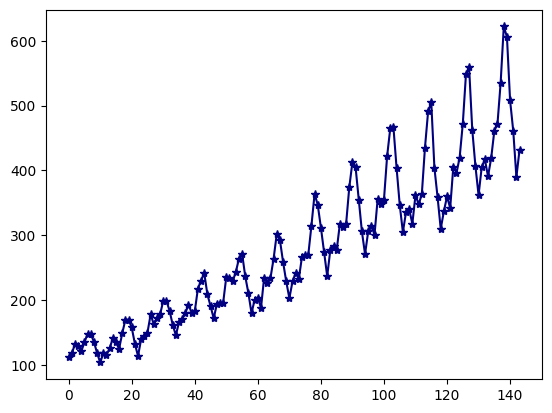

In [29]:
import matplotlib.pyplot as plt
plt.plot(df["Passengers"],color="navy",marker="*")
plt.show()

In [30]:
timeseries = df[["Passengers"]].values.astype('float32')

In [31]:
train_size=int(len(timeseries)*0.67)
test_size=len(timeseries)-train_size
train,test=timeseries[: train_size],timeseries[train_size:]

In [32]:
def create_dataset(dataset,lookback):
  X=[]
  y=[]
  for i in range(len(dataset)-lookback):
    feature=dataset[i:i+lookback]
    target=dataset[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)
  return torch.tensor(X),torch.tensor(y)


In [33]:
lookback=1
x_train,y_train=create_dataset(train,lookback=lookback)
x_test,y_test=create_dataset(test,lookback=lookback)

In [34]:
print(f"Train Data Shape : {x_train.shape}\nTrain Label Shape : {y_train.shape}")
print("============================================================================")
print(f"Test Data Shape : {x_test.shape}\nTest Label Shape : {y_test.shape}")

Train Data Shape : torch.Size([95, 1, 1])
Train Label Shape : torch.Size([95, 1, 1])
Test Data Shape : torch.Size([47, 1, 1])
Test Label Shape : torch.Size([47, 1, 1])


In [35]:
import torch.nn as nn

class airmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm=nn.LSTM(input_size=1,hidden_size=50,num_layers=1,batch_first=True)
    self.linear=nn.Linear(50,1)

  def forward(self,x):
    x,_=self.lstm(x)
    x=self.linear(x)
    return x




In [38]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model=airmodel()
optimizer=optim.Adam(model.parameters())
loss_fn=nn.MSELoss()
loader=data.DataLoader(data.TensorDataset(x_train,y_train),shuffle=True,batch_size=32)

In [40]:
epochs=2000
for epoch in range(epochs):
  model.train()
  for x_batch,y_batch in loader:
    y_pred=model(x_batch)
    loss=loss_fn(y_pred,y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  #validation

  if epoch%100!=0:
    continue
  model.eval()
  with torch.no_grad():
    y_pred=model(x_train)
    train_rmse=np.sqrt(loss_fn(y_pred,y_train))
    y_pred=model(x_test)
    test_rmse=np.sqrt(loss_fn(y_pred,y_test))
  print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 132.0433, test RMSE 321.4254
Epoch 100: train RMSE 125.6882, test RMSE 314.0300
Epoch 200: train RMSE 119.5931, test RMSE 306.7800
Epoch 300: train RMSE 113.7749, test RMSE 299.6787
Epoch 400: train RMSE 108.2542, test RMSE 292.7326
Epoch 500: train RMSE 103.0583, test RMSE 285.9556
Epoch 600: train RMSE 98.2094, test RMSE 279.3559
Epoch 700: train RMSE 93.5139, test RMSE 272.8924
Epoch 800: train RMSE 88.7111, test RMSE 266.3748
Epoch 900: train RMSE 84.0409, test RMSE 259.8536
Epoch 1000: train RMSE 79.5951, test RMSE 253.4022
Epoch 1100: train RMSE 75.3763, test RMSE 247.0597
Epoch 1200: train RMSE 71.3674, test RMSE 240.8255
Epoch 1300: train RMSE 67.5648, test RMSE 234.7134
Epoch 1400: train RMSE 63.9717, test RMSE 228.7112
Epoch 1500: train RMSE 60.6168, test RMSE 222.8268
Epoch 1600: train RMSE 57.4075, test RMSE 217.0551
Epoch 1700: train RMSE 54.4115, test RMSE 211.3980
Epoch 1800: train RMSE 51.6106, test RMSE 205.8563
Epoch 1900: train RMSE 48.9893, test 

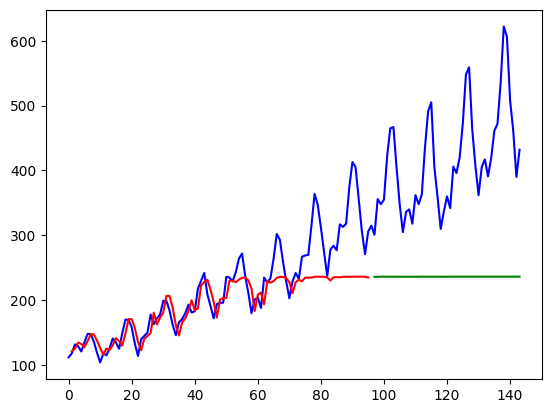

In [42]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(x_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(x_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(x_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# Reference
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
